In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

# Introduction to Ensemble Methods

Ensemble methods are techniques for obtaining better predictive performances by using multiple models.

To get an overview of the methods we are going to see today, you can watch this video of Machine learnia about Ensemble learning : https://www.youtube.com/watch?v=7C_YpudYtw8 (you don't need to understand everything before beginning the notebook ;)).

The following dataset comes from a bank which would like to know when a new client arrives if this client will subscribe to a long term deposit.

The bank will be considered as your client in the following parts.

---

**Feel free to create sklearn Pipelines for simplifying the following experiments** 

## Introducing and exploring the dataset

The dataset is located in `../data/bank-full.csv`. It has 17 columns, the target column or $ŷ$ is the column named `y`.

Columns summary  : 

| column name | simple description |
|-------------|------------------------|
| age | age |
| job | type of job |
| marital | marital status |
| education | education level |
| default | has credit in default? |
| balance | average yearly balance, in euros  |
| housing | has housing loan? |
| loan | has personal loan? |
| contact | contact communication |
| month | last contact month of year |
| ~~day_of_week~~ | ~~last contact day of the week~~ |
| duration |  last contact duration in seconds |
| campaign |  number of contacts performed during campaign for this client |
| pday | number of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client |
| poutcome | outcome of the previous marketing campaign |
| **output :** |  |
| y | has  the client subscribed a term deposit? |

Let's explore the dataset a bit using pandas.

While exploring the dataset it is recommended to create a list of categorical features

In [2]:
import pandas as pd

Create a dataframe with the dataset `../data/bank-full.csv`

In [3]:
# code here
df = pd.read_csv("../data/bank-full.csv", sep=";")

Describe the dataset informations

In [4]:
# code here
num_columns=['age','balance','day','duration','campaign','pdays','previous']
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

Use histogramms to display the features' distribution

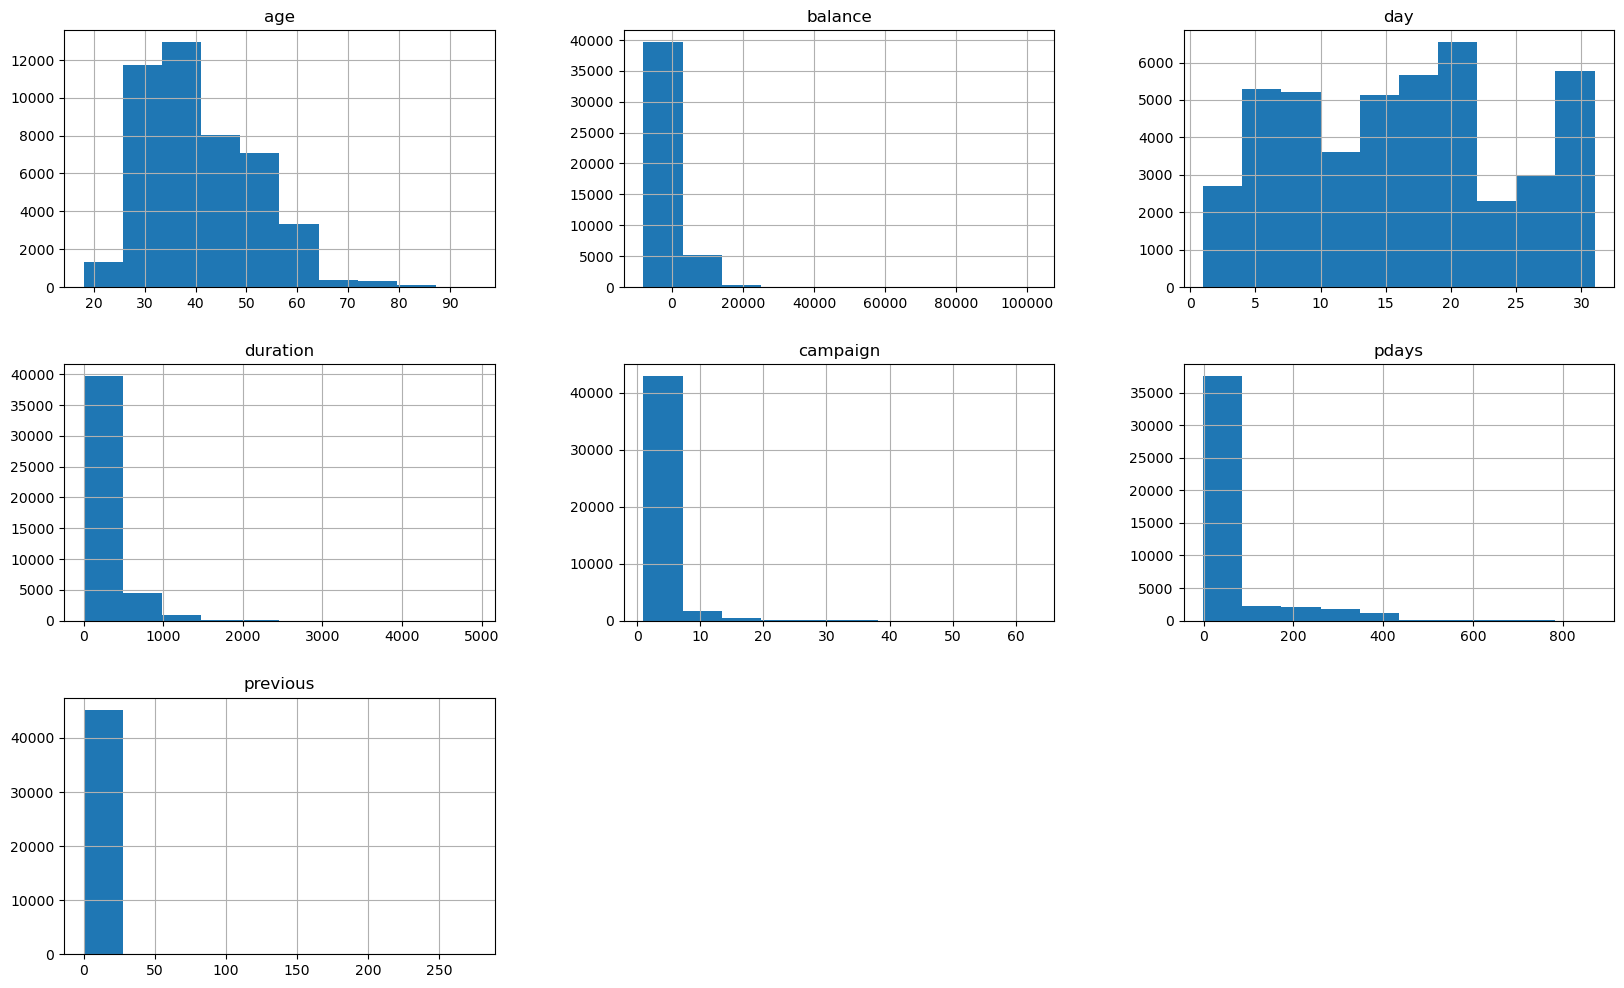

In [6]:
# code here
rcParams['figure.figsize'] = 20,12
df.hist()
plt.show()

Use heatmap to display the numerical features' correlation

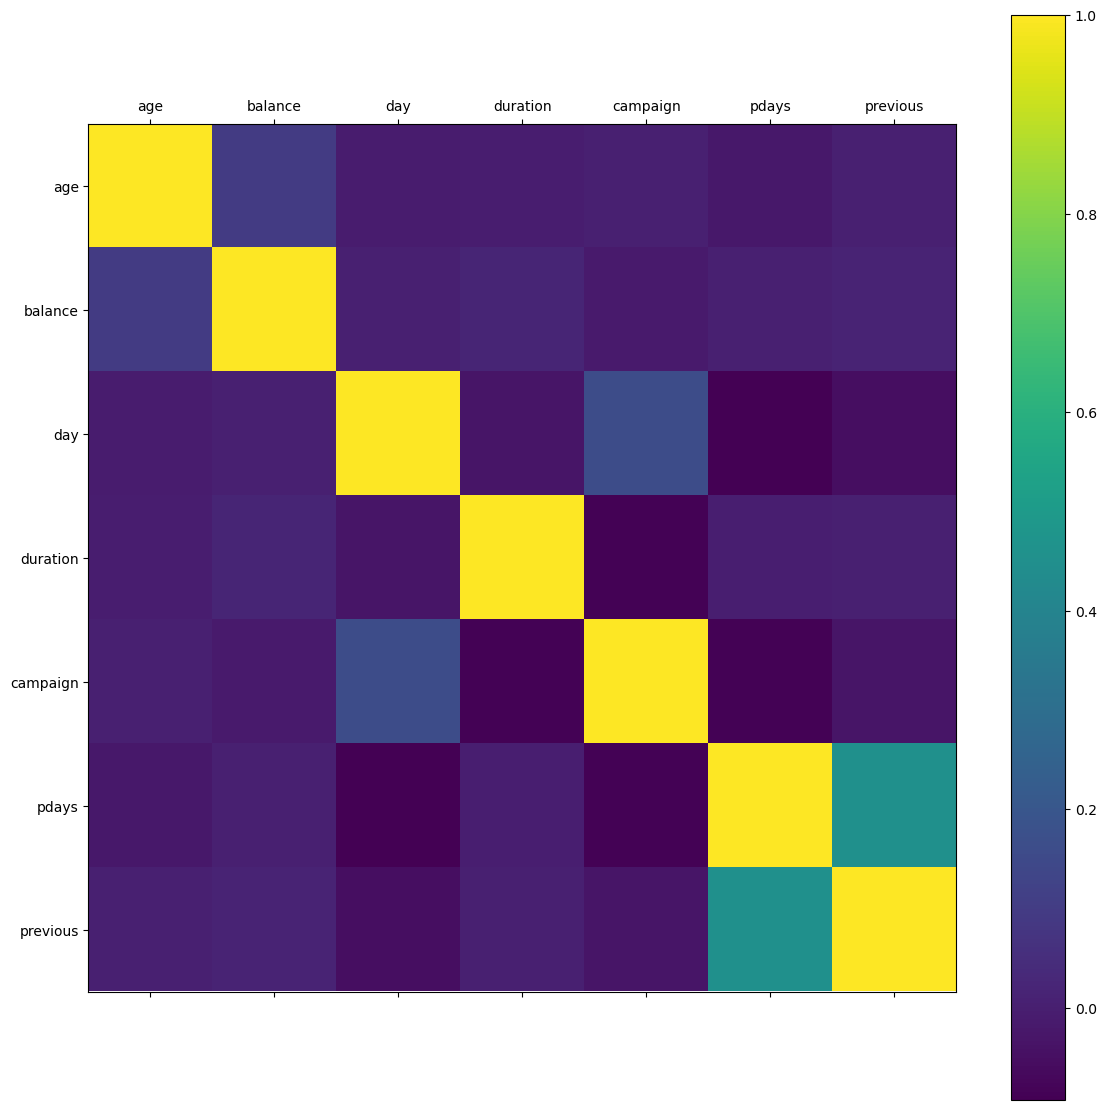

In [7]:
# code here
rcParams['figure.figsize'] = 20, 14
plt.matshow(df[num_columns].corr())
plt.yticks(np.arange(len(num_columns)), num_columns)
plt.xticks(np.arange(len(num_columns)), num_columns)
plt.colorbar()
plt.show()

## Clean

Hop hop hop!!! Not to fast!! Before processing data for machine learning, do you think that all the data are useful?  
As an expert, I tell you you should removed the duration column!!

Could you tell me why?\
**Data leakage because client signing up could be linked going through papers for signing. Also short if they don't want the product.**

💡*think first, but if you have no idea double click here.*
<!-- When do your calls last the most? --> 

In [8]:
# remove duration column
df.drop(columns='duration',inplace=True)

The date is a strange type of data for machine learning. Think about it. Is the day? the month? the year that are important? Or the relative date for instance in the year?

If the phenomenon occurs seasonally, maybe it is better to look at the day of the year (on 365 days), if it monthly, maybe to look at the day in the month (on approximativally 30, 31 or other for bissextile year), etc... If more complex, well do the proper hypothesis and test it.

For our problem, we supposed it is better to look at the day of the year. Maybe it is a good hypothesis, maybe not. It is an hypothesis we want you to test. So in order to continue the preprocessing, the features `day` and `month` should be merged into one column named `dayoftheyear`. 

You can use pandas datetime tools or python **datetime** librairies for doing this preprocessing. To find the the day of year, look as *dayofyear* method from **datetime** library and examples such as https://pythonguides.com/extract-day-number-of-the-year-from-a-date-in-python/ or https://docs.lucee.org/reference/functions/dayofyear.html
(the default year used will be 1984)

In [9]:
#code here
# You can concatenate multiple Series containing string by just summing them.
# However, be sure each Serie contains string, in case use .astype(str)
import datetime
df['day_of_year'] = '1984-'+df['month']+'-'+df['day'].astype(str)

In [10]:
df['day_of_year']=pd.to_datetime(df['day_of_year'], format="%Y-%b-%d")
df['day_of_year']=df['day_of_year'].dt.dayofyear
df.drop(columns=['day','month'], inplace=True)

In [11]:
df['day_of_year'].sample(5)

228      126
30529     36
39217    139
16226    205
10471    168
Name: day_of_year, dtype: int32

We cannot treat the same way categories with numerical features. So let's make two different lists and different treatments. 

Now sort the features into categorical and numerical features

## Pipeline

In [12]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'y',
       'day_of_year'],
      dtype='object')

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

In [14]:
unicategorical_features = ['default','housing','loan'] #completed
multicategorical_features=['job','marital','education','poutcome','contact'] #completed
numerical_features = ['age','balance','campaign','pdays','previous','day_of_year'] #completed

# Pipeline
multicat_pipeline=Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error'))
])

unicat_pipeline=Pipeline([
    ('encoder', OrdinalEncoder(categories=[['no','yes'], ['no','yes'], ['no','yes']]))
])

num_pipeline=Pipeline([
    ('scaler',StandardScaler())
])

#Column transformer
preprocessor=ColumnTransformer([
    ('multicat', multicat_pipeline, multicategorical_features),
    ('unicat', unicat_pipeline, unicategorical_features),
    ('num',num_pipeline, numerical_features)
])

After a first exploration, categorical/ordinal features (8 columns) need to be encoded in order to become a valid input for the modeling phase. ML manipulates figures, not string, not category by itself.

Look at the encoder to *encode* your *categorical data*. The different encoders can be found [here](https://scikit-learn.org/stable/api/sklearn.preprocessing.html).

(You can also use the function `gethg_dummies` of pandas for categorical features)

## Train-test split

In [15]:
# Create the X and y DataFrames, resample the dataframes if necessary
# import and create the appropriate transformers 
X=df.drop(columns='y')
y=df['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.3,
    random_state=41
)

At the end of this part, two dataframes are created :

- `X` containing the features (or the matrix $X$)
- `y` containing the label (or $ŷ$)

Well done! The data is now ready to be splitted into sets and used to train models!

## Modelling phase

The client needs two features :

1. A model, which can be updated without performance loss. In other word, it means a pipeline easy to use and evaluate.
2. A model, that performs well.

### Dummy Classifier

It is always a good idea to begin with a dummy model as a baseline

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


# Code here to get dummy classifier F1score and accuracy
dummy_model=Pipeline([
    ('preprocessor',preprocessor),
    ('model', DummyClassifier())
])

dummy_model.fit(X_train, y_train)

y_test_dummy_pred=dummy_model.predict(X_test)

In [17]:
def print_scores(name, y, y_pred, zero_division='warn', pos_label='yes', give_return=False):
    f1_score_l=f1_score(y, y_pred, pos_label=pos_label)
    accuracy_score_l=accuracy_score(y, y_pred)
    recall_score_l=recall_score(y, y_pred, pos_label=pos_label)
    precision_score_l=precision_score(y, y_pred, pos_label=pos_label, zero_division=zero_division)
    print(
        "-"*3 +" "+ name+" "+"-"*3+"\n"+
        "Accuracy: {:02.01f} %\n".format(accuracy_score_l*100)+
        "Recall: {:02.01f} %\n".format(f1_score_l*100)+
        "Precision: {:02.01f} %\n".format(recall_score_l*100)+
        "F1 score: {:02.01f} %\n".format(precision_score_l*100)
    )
    if give_return==True:
        return f1_score, accuracy_score, recall_score, precision_score

In [18]:
print_scores("Dummy", y_test, y_test_dummy_pred, pos_label='yes', zero_division=0)

--- Dummy ---
Accuracy: 88.0 %
Recall: 0.0 %
Precision: 0.0 %
F1 score: 0.0 %



### Simple Decision Tree

We will experiment both feature by doing the two following steps.

* Training the Decision Tree model with various splits of the dataset (change the `random_state` parameter of the `train_test_split` function for obtaining the second dataset)
* The decision tree `max_depth` will be fixed at 3 first

if you need more info you can take a look at the [sklearn decision tree doc](https://scikit-learn.org/stable/modules/tree.html).

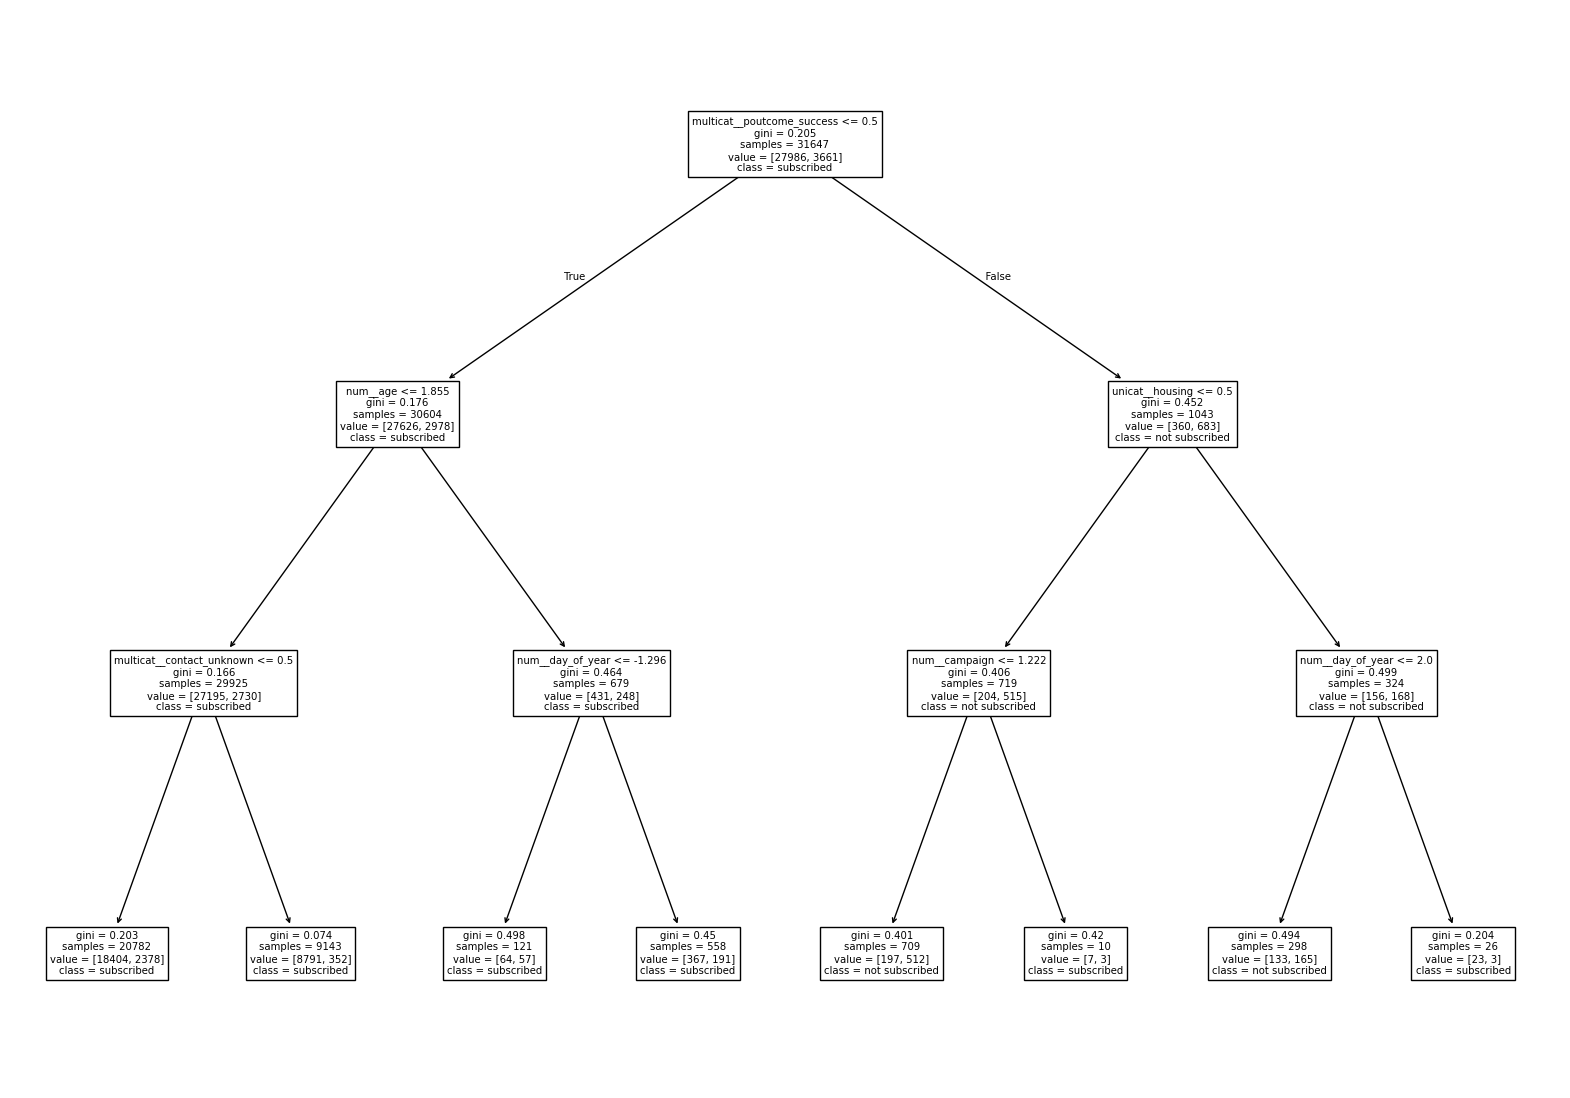

In [19]:
# Decision tree model creation
from sklearn.tree import DecisionTreeClassifier
tree_model=Pipeline([
    ('preprocessor',preprocessor),
    ('model', DecisionTreeClassifier(max_depth=3))
])

tree_model.fit(X_train, y_train)

#Tree visualization
from sklearn.tree import plot_tree

plot_tree(
    tree_model['model'],
    feature_names=tree_model['preprocessor'].get_feature_names_out(),
    class_names=['subscribed','not subscribed']
)
plt.show()

Now, a first model has been created, change the random seed for the train/test split, and create another tree.

This tree should be created with the same hyperparameters than above. 

In [20]:
# create a new train and test dataset with a different seed
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X,y,
    test_size=0.3,
    random_state=28 #lecornu1
)

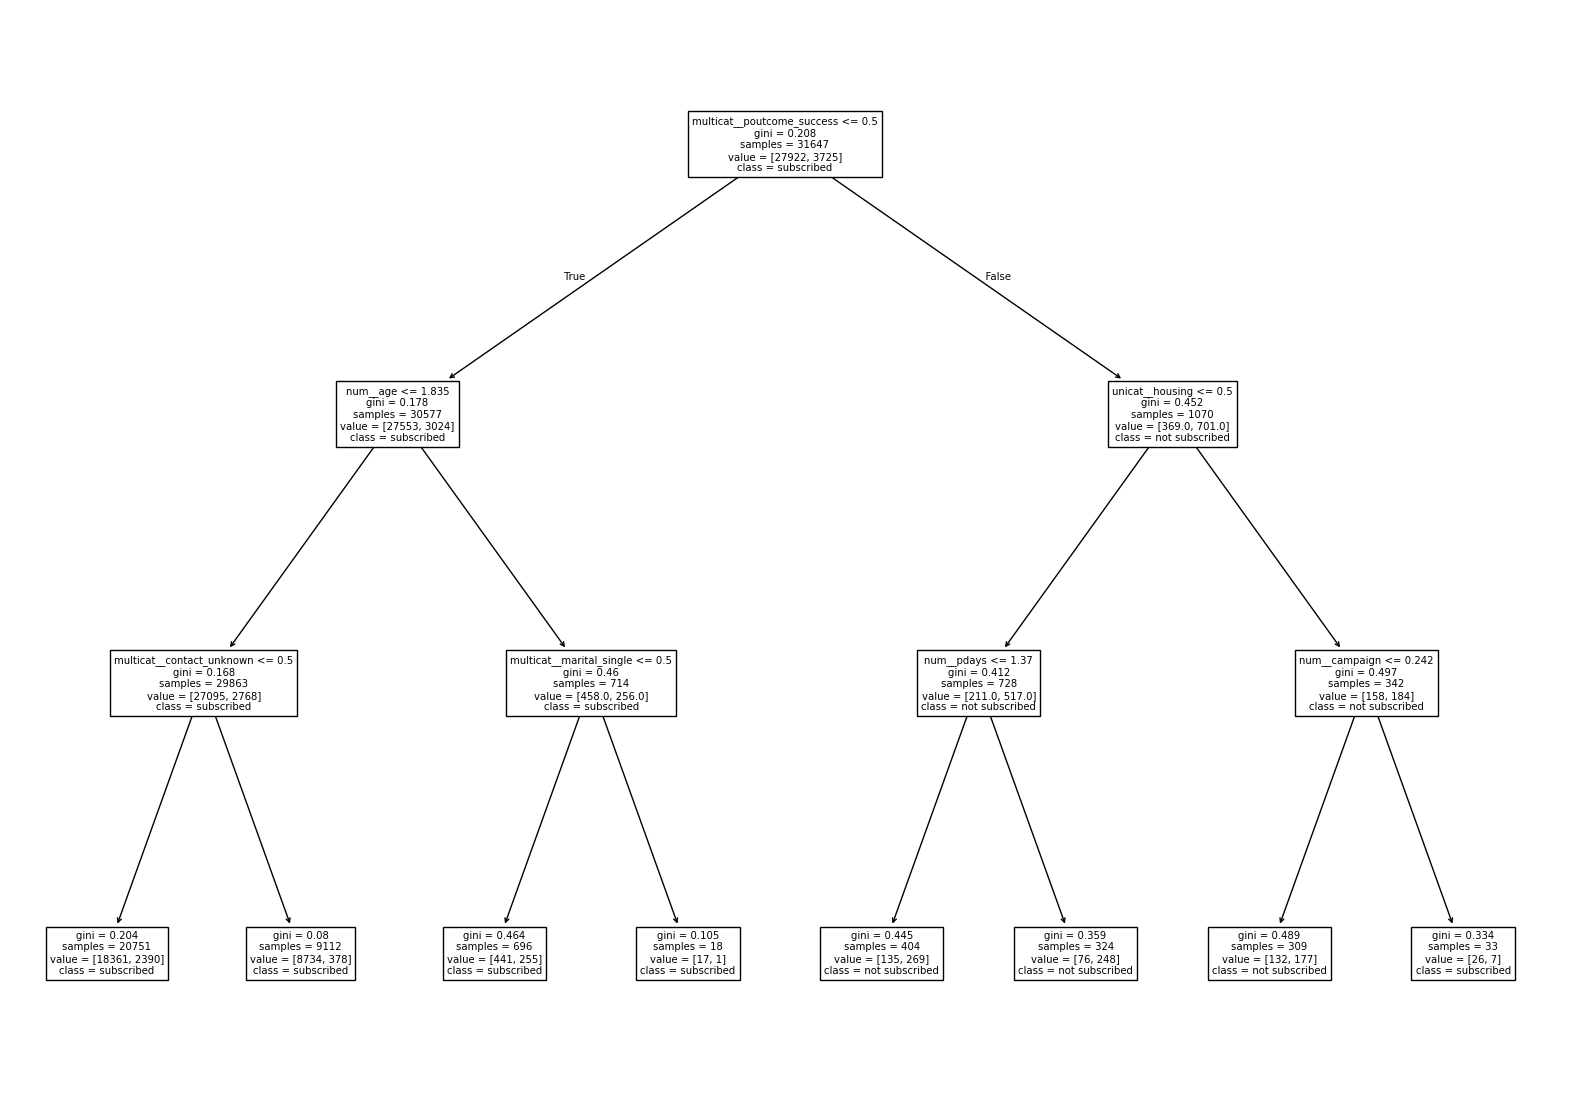

In [21]:
# Second tree creation
tree_model2=Pipeline([
    ('preprocessor',preprocessor),
    ('model', DecisionTreeClassifier(max_depth=3))
])

tree_model2.fit(X_train2, y_train2)

#Tree visualization
from sklearn.tree import plot_tree

plot_tree(
    tree_model2['model'],
    feature_names=tree_model2['preprocessor'].get_feature_names_out(),
    class_names=['subscribed','not subscribed']
)
plt.show()

**What can you tell about the two trees?**

> The first two depth are the same but the last one has slighty different value

In [22]:
print_scores("Tree 1", y_test, tree_model.predict(X_test2))
print_scores("Tree 2", y_test2, tree_model2.predict(X_test2))

--- Tree 1 ---
Accuracy: 85.5 %
Recall: 4.2 %
Precision: 2.6 %
F1 score: 10.2 %

--- Tree 2 ---
Accuracy: 89.3 %
Recall: 27.2 %
Precision: 17.3 %
F1 score: 63.3 %



Normally, before creating a model, one or more evaluation metrics should be chosen depending on the client problem.

* Choose different metrics that seem relevant to this problem (see previous lesson on Classification)

* Prepare a scoring list for these metrics.

* Use the cross-validation method to measure these metrics (if you need see : [cross validation sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)). 

*Hint:*  the `cross_validate` method allows you to pass a metric list as parameter (see [doc here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ).

**Test if the target is balanced**

Text(0.5, 1.0, 'Count of each Target Class')

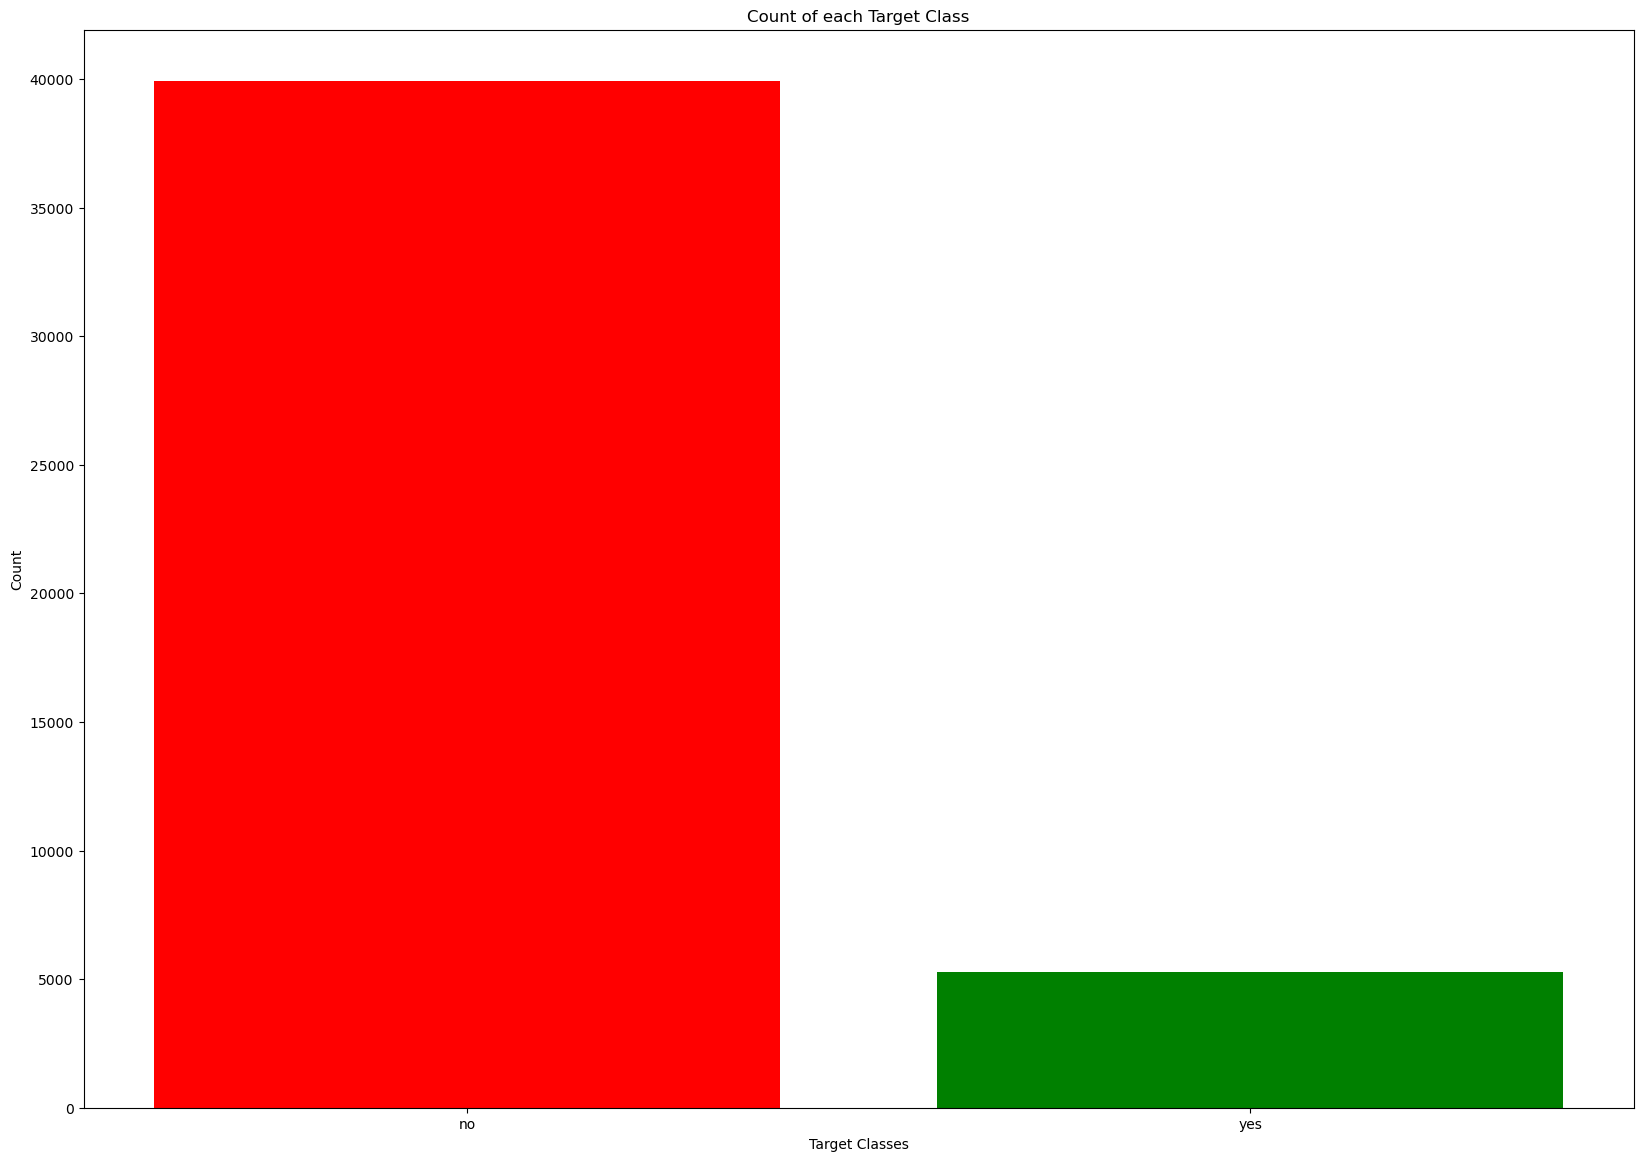

In [23]:
plt.bar(df['y'].unique(), df['y'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

In [24]:
# Cross validation on Decision trees
from sklearn.model_selection import cross_validate
metrics = [accuracy_score, f1_score]

y_train2=y_train2.replace({'yes':'1','no':'0'}).astype(int)

In [36]:
cv_scores=cross_validate(
    tree_model2,
    X_train2, y_train2,
    cv=5,
    n_jobs=-1,
    scoring=['accuracy','f1','recall','precision']
)

Now process the output of your cross-validation in order to know the diversity in performances and the average performance

In [45]:
#Bonus : Plot your metrics performance
scores=['test_accuracy','test_f1','test_recall','test_precision']
for score in scores:
    mean=np.mean(cv_scores[score])
    std=np.std(cv_scores[score])
    print(score[5:]+u": {:02.1f}\u00B1{:02.1f}%".format(mean*100, std*100))

accuracy: 89.3±0.1%
f1: 27.7±2.3%
recall: 17.4±1.8%
precision: 67.4±1.5%


In [26]:
# BONUS: performance plot 
# Create a bar plot showing the mean and the standard deviation for each metric

Now choose a single metric to perform a grid search on the `max_depth` of the tree.

In [52]:
# Grid search
from sklearn.model_selection import GridSearchCV

param_grid={"model__max_depth":[3,4,5,6,7,8,9]}

tree_model_grid=Pipeline([
    ('preprocessor',preprocessor),
    ("model",DecisionTreeClassifier())
])
grid_search=GridSearchCV(
    tree_model_grid,
    param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-2
)

grid_search.fit(X_train2, y_train2)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__max_depth': [3, 4, ...]}"
,scoring,'average_precision'
,n_jobs,-2
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('multicat', ...), ('unicat', ...), ...]"


In [54]:
max_depth=grid_search.best_params_['model__max_depth']

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [ ]:
# Test metrics
model=grid_search.best_estimator_ #already done by grid search

y_test2_pred=model.predict(X_test2)
y_test2=y_test2.replace({'yes':'1','no':'0'}).astype(int)

print_scores(f"Decision Tree with max_depth={max_depth}",y_test2,y_test2_pred, pos_label=1)

--- Decision Tree with max_depth=8 ---
Accuracy: 89.2 %
Recall: 27.3 %
Precision: 17.5 %
F1 score: 61.9 %



**What are your observation?**
> The model is accurate for negative answer

**By looking at the metric results, what is strange? Or at the opposite, obvious?**
> The inbalance in the Y target make the model a good predictor of people that are not subscribed but we want the opposite.

**From theses observations, what are your conclusions?**
> I have to put weights in my model

In the next sessions, we will look at ensembling to improve performances. But what should you be suspicious? What are the potential risks you identified?  

Propose something, continue to the next section and change your conclusions if you need.

### Introducing Ensemble Learning with Bagging models.

Let's train multiple classifiers in parallel in a bootstraping approach! 

Bagging stands for ***Boostrap AGGregatING***.

The following [post](https://blog.octo.com/les-methodes-ensemblistes-pour-algorithmes-de-machine-learning/) will give you an overview of these methods and their advantages and drawbacks

**The train test split using a seed equals to 42 will be used in the following part**

In [29]:
# train_test split (you can copy paste the previously declared cell)
# X_train, X_test, y_train, y_test = None

#### Using Random Forest

The concept of random forest is explained in this [post](https://medium.com/analytics-vidhya/understanding-the-random-forest-algorithm-79b87bdde79a).

Now the best parameters of the previous classifier will be used in a using a bagging classifier
[sklearn : Random Forest Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

We will use grid search on the `n_estimators` and `max_depth` parameters. 

In [30]:
# gridsearch for the Random Forest classifier
#

How much estimators should we use for obtaining an optimal result? (in terms of time and performance)

*answer here*

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [31]:
# Test metrics

#### Other Random Forest effect

The random forest model can attribute an importance value to features, [explanations here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

Let's train another random forest and display an histogramm with it :

In [32]:
# display features' importance => use the RandomForest Object

What is the most important feature?

*Answer here*

A lot of features have low importance and probably add noise which reduce the performance of the classifier, do a feature selection by recursive elemination to automatically select the subset of features that gives you the best model predictions.

You can have a look at : 

https://scikit-learn.org/stable/modules/feature_selection.html

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [33]:
# Feature selection with recursive elimination
# Do another grid search on your model with the subset of selected features

We removed the duration feature in our dataset

Read this feature description on the dataset description ([here on data.world](https://data.world/uci/bank-marketing) or [here on kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset)).

How would the previously trained models perform with this feature?

*Answer here*

### Continue Ensemble Learning with boosting techniques

Bagging permits to average the results of separated models, whereas the boosting technique trains a classifier and optimizes it in function of its error.

Some information about boosting techniques are on the [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) but a commonly used library for these techniques is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) there are some compatibilities with the sklearn methods (gridsearch, cross validation,...)

- install the `xgboost` package

*Read the articles in resources for a complete explanation.*

In this part a classifier will be trained and evaluated.

In [34]:
# use the same split and seed than you used before
# normally, you have nothing to code here :D 

*Hint:* An example for integrating `XGBoost` with  the `sklearn` tools is available [here](https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a)

In [35]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

Let's build a new model than before with a grid search on the `n_estimators` and `max_depth` parameters.

In [ ]:
# model building and evaluation

In [ ]:
# gridsearch 

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [ ]:
# Test metrics

In [ ]:
# performance curves

## Let's Conclude

Report your test set metrics for the three methods here

In [ ]:
# Decision Tree on test set

In [ ]:
# Random forest on test set

In [ ]:
# XGBoost on test set

What do you notice? What are you real conclusion about the dataset? What should you tell the client about the dataset and his problem?

*answer here*

- Write your memo about bagging and boosting method in a cell below.
- Which model would you choose for the bank, and why? Which precautions?

you can add your models result visualization in this cell if it helps you explaining your conclusions.

                                 `write memo here`

## To go further

### Build a customized bagging classifier (Optional) 

- Use a different classification model you have seen until now and build a new classifier based on the [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) to create and train an new model.
- Use differents classification models and use the [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) to create and train a new model.

In [ ]:
# Write your code here

## Rebalance the data if you haven't done it yet

Before going through the modelling phase, let's see the label distribution :

Use the `value_counts` function and the appropriate visualization for displaying the label distribution

In [ ]:
# code here

What do you notice?

*answer here*

The easiest way to rebalance your data is to add the `class_weight='balanced'` parameter to your scikit learn model. The `class_weight` parameter is available in most scikit-learn models, for example look at the Decision Trees doc :
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

(There are other techniques for rebalancing the data [here](https://blog.octo.com/donnees-desequilibrees-que-faire/), [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) ).

Rebalance the data with the `class_weight` parameter, and you'll have much better f1 and Average Precision metrics.

In [ ]:
# code here